In [1]:
%load_ext autoreload
%autoreload 2

import util
import numpy as np
import os

import pandas as pd
import ipdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import grid2op
import re
import tutor_data_processing as tdp
import functools
from action_space.generate_action_space import action_identificator
import json
import math
from Tutor.Generate_teaching_dataset import init_env
from sklearn.metrics import confusion_matrix

In [2]:
config = util.load_config()
tutor_data_path = config['paths']['tutor_imitation']
output_data_path = config['paths']['processed_tutor_imitation']
con_matrix_path = config['paths']['con_matrix_cache']
fstats_path = config['paths']['feature_statistics']

# Data Processing

In [3]:
def process_raw_tutor_data():
    #Initialize environment and environment variables
    env = init_env(config)
    grid2op_vect_size = len(env.get_obs().to_vect())
    thermal_limits = config['rte_case14_realistic']['thermal_limits']
        
    #Create a an object for caching connectivity matrices
    cmc = tdp.ConMatrixCache()
    #Create a dictionary used for finding actions corresponding to action ids
    action_iders = {}
    #Create object for tracking the feature statistics
    fstats = tdp.FeatureStatistics()

    for fp in tqdm(tdp.get_filepaths(tutor_data_path)):
        line_disabled, _, chronic_id, dayscomp = tdp.extract_data_from_filepath(fp.relative_to(tutor_data_path))
        
        #Load a single file with raw datapoints
        chr_ldis_raw_dps = np.load(fp)

        #If it doesn't already exit, reate action_identificator for this particular line disabled
        #Action identificator give the action corresponding to an action index
        if line_disabled not in action_iders:
            action_iders[line_disabled] = action_identificator(line_disabled)

        #Create a list wherein to store the processed datapoints for this particular file
        file_dps = []

        #Env information specifically for a line removed
        env_info_dict = tdp.env_info_line_disabled(env, line_disabled)

        #Loop over the datapoints
        for raw_dp in chr_ldis_raw_dps:
            #Extract information dictionary from the datapoint
            dp = tdp.extract_data_from_single_ts(raw_dp,
                                                 grid2op_vect_size,
                                                 env.observation_space.from_vect,
                                                 line_disabled,
                                                 env_info_dict,
                                                 thermal_limits)
            
            #Add the data from the filepath and environment to the data dictionary
            dp.update({'line_disabled':line_disabled, 'chronic_id':chronic_id, 'dayscomp':dayscomp})
            dp.update({'sub_info':env_info_dict['sub_info'],
                       'gen_pos_topo_vect':env_info_dict['gen_pos_topo_vect'],
                       'load_pos_topo_vect':env_info_dict['load_pos_topo_vect'],
                       'line_or_pos_topo_vect':env_info_dict['line_or_pos_topo_vect'],
                       'line_ex_pos_topo_vect':env_info_dict['line_ex_pos_topo_vect'],
                      })

            #Update the feature statistics.
            fstats.update_feature_statistics(dp)
            
            #Find the set action topology vector and add it to the datapoint
            if dp['action_index'] != -1:
                dp['set_topo_vect'] = action_iders[line_disabled].get_set_topo_vect(dp['action_index'])
                #Remove disables lines from topo vect objects
                if line_disabled != -1:
                    dp['set_topo_vect'] = np.delete(dp['set_topo_vect'],[
                                                    env_info_dict['dis_line_or_tv'],
                                                    env_info_dict['dis_line_ex_tv']])
            else:
                dp['set_topo_vect'] = np.zeros_like(dp['topo_vect'])

            dp['change_topo_vect'] = np.array([0 if s==0 else abs(t-s) for t,s in zip(dp['topo_vect'],dp['set_topo_vect'])])
            dp['res_topo_vect'] = np.array([t if s==0 else s for t,s in zip(dp['topo_vect'],dp['set_topo_vect'])])

            #Skip datapoint if any other line is disabled
            if -1 in dp['topo_vect']:
                continue

            assert len(dp['set_topo_vect']) == len(dp['topo_vect']) == len(dp['change_topo_vect']) \
                    == len(dp['res_topo_vect']) , "Not equal lengths"
            assert len(dp['topo_vect']) == (56 if line_disabled == -1 else 54), "Incorrect length"
            assert all([(o in [0,1,2]) for o in dp['set_topo_vect']]), "Incorrect element in set_topo_vect"
            assert all([(o in [1,2]) for o in dp['topo_vect']]), "Incorrect element in topo_vect"
            assert all([(o in [0,1]) for o in dp['change_topo_vect']]), "Incorrect element in change_topo_vect"
            assert all([(o in [1,2]) for o in dp['res_topo_vect']]), "Incorrect element in res_topo_vect"

            #Add the index of the connectivity matrix to the data object
            cm_index = cmc.get_key_add_to_dict(dp['topo_vect'],
                                               line_disabled,
                                               env_info_dict['sub_info'],
                                               env_info_dict['line_or_pos_topo_vect'],
                                               env_info_dict['line_ex_pos_topo_vect'])
            dp['cm_index'] = cm_index
            assert dp['cm_index'] in cmc.con_matrices

            #Append datapoint to the datapoints for a particular chronic and line disabled, update summary object
            file_dps.append(dp)

        #Save the processed datapoints for a particular chronic and line disabled
        tdp.save_data_to_file(file_dps, output_data_path)
        
    cmc.save(con_matrix_path)
    fstats.save_feature_statistics(fstats_path)

In [4]:
process_raw_tutor_data()

100%|██████████| 14415/14415 [1:50:27<00:00,  2.17it/s]     


# Data Analysis

In [5]:
from pathlib import Path
import collections
from scipy.stats import entropy
from scipy.spatial import distance

In [6]:
def tv_groupby_subst(tv, sub_info):
    i = 0
    gs = []
    for ss in sub_info:
        gs.append(tv[i:i+ss])
        i+=ss
    return gs

In [7]:
counters = {} 
hash_to_act = {}
hash_to_res = {}
n_sub = 14

for i in np.arange(-1,20):
    counters[i] = {
        'n_datapoints':0,
        'n_days_completed':0,
        'n_chronics':0,
        'set_hash': collections.Counter(),
        'res_hash': collections.Counter(),
        'sub_changed': (n_sub+1) * [0],
        'changed_subs_n': n_sub * [0],
        'sub_info': []
    }
        
        

for f in tqdm(list(Path(output_data_path).rglob('*.json'))):
    with open(f, 'r') as file:
            dps = json.loads(file.read())
            
    line_disabled = dps[0]['line_disabled']
    
    counters[line_disabled]['n_chronics']+=1
    counters[line_disabled]['n_days_completed']+=dps[0]['dayscomp']
    for dp in dps:
        #Increase n. datapoints
        counters[line_disabled]['n_datapoints']+=1
        
        #Count set_topo_vect
        hsh_set = tdp.hash_nparray(np.array(dp['set_topo_vect']))
        if hsh_set not in hash_to_act:
            hash_to_act[hsh_set] = dp['set_topo_vect']
        counters[line_disabled]['set_hash'][hsh_set]+=1
        
        #Count res_topo_vect
        hsh_res = tdp.hash_nparray(np.array(dp['res_topo_vect']))
        if hsh_res not in hash_to_res:
            hash_to_res[hsh_res] = dp['res_topo_vect']
        counters[line_disabled]['res_hash'][hsh_res]+=1
        
        #Count substations affected
        action_per_sub = tv_groupby_subst(dp['set_topo_vect'],dp['sub_info'])
        try:
            changed_subs_id = [np.any(a) for i,a in enumerate(action_per_sub)].index(True)
            counters[line_disabled]['sub_changed'][changed_subs_id] += 1
        except:
            counters[line_disabled]['sub_changed'][-1] += 1

        #Count topological depth of resulting topologies
        #ASSUMPTION: reference topology is the topology where all objects are connected to bus 1
        res_per_sub = tv_groupby_subst(dp['res_topo_vect'],dp['sub_info'])
        changed_subs_n = sum([2 in res for i,res in enumerate(res_per_sub)])
        counters[line_disabled]['changed_subs_n'][changed_subs_n] += 1
        
        #Set sub info
        counters[line_disabled]['sub_info'] = dp['sub_info']
        

        

100%|██████████| 14082/14082 [07:35<00:00, 30.92it/s]


#### Number of chronics

In [8]:
line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]

In [9]:
sum([v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider])

13998

#### Percentage days completed

In [10]:

print([(k,v['n_days_completed']/(28*v['n_chronics']))for k,v in counters.items() if k in line_disabled_to_consider])

[(-1, 0.9973214285714286), (0, 0.996), (1, 0.9989285714285714), (2, 0.9969642857142857), (3, 0.9961071428571429), (4, 0.9986428571428572), (5, 0.9964642857142857), (6, 0.9477142857142857), (10, 0.9771071428571428), (12, 0.9756428571428571), (13, 0.93125), (15, 0.8316785714285714), (16, 0.9480714285714286), (19, 0.680647008302319)]


In [11]:
line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
line_group1 = [-1,0,1,2,3,4,5,6,12]
line_group2 = [13,15,16,19]
print(sum([v['n_days_completed']for k,v in counters.items() if k in line_disabled_to_consider])/ \
sum([28*v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider]))
print(sum([v['n_days_completed']for k,v in counters.items() if k in line_group1])/ \
sum([28*v['n_chronics']for k,v in counters.items() if k in line_group1]))
print(sum([v['n_days_completed']for k,v in counters.items() if k in line_group2])/ \
sum([28*v['n_chronics']for k,v in counters.items() if k in line_group2]))

0.948076766068622
0.9893095238095239
0.8479954262845708


#### Number of datapoints

In [12]:
[(k,v['n_datapoints'])for k,v in counters.items() if k in line_disabled_to_consider]

[(-1, 25993),
 (0, 28372),
 (1, 29082),
 (2, 29859),
 (3, 31414),
 (4, 29205),
 (5, 28975),
 (6, 57358),
 (10, 53582),
 (12, 57246),
 (13, 173021),
 (15, 117082),
 (16, 84012),
 (19, 342084)]

In [13]:
print(sum([v['n_datapoints']for k,v in counters.items() if k in line_disabled_to_consider]))
print(sum([v['n_datapoints']for k,v in counters.items() if k in line_group1]))
print(sum([v['n_datapoints']for k,v in counters.items() if k in line_group2]))

1087285
317504
716199


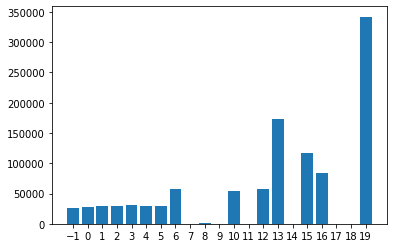

In [14]:
plt.bar(np.arange(-1,20),[counters[l]['n_datapoints'] for l in np.arange(-1,20)])
ax = plt.gca()
_ = ax.set_xticks(np.arange(-1,20))

#### Action statistics

In [15]:
[(k,len(v['set_hash']))for k,v in counters.items()]

[(-1, 74),
 (0, 56),
 (1, 62),
 (2, 49),
 (3, 44),
 (4, 51),
 (5, 50),
 (6, 55),
 (7, 5),
 (8, 64),
 (9, 0),
 (10, 71),
 (11, 0),
 (12, 76),
 (13, 74),
 (14, 0),
 (15, 66),
 (16, 60),
 (17, 21),
 (18, 0),
 (19, 63)]

Percentage of do-nothing actions

In [16]:
do_nothing_action_hashes = [h for h,t in hash_to_act.items() if sum(t)==0]
[(k,(v['set_hash'][do_nothing_action_hashes[0]]+v['set_hash'][do_nothing_action_hashes[1]])/v['n_datapoints'])
 for k,v in counters.items() if k in line_disabled_to_consider]

[(-1, 0.07151925518408803),
 (0, 0.12121105315099394),
 (1, 0.13953648304793342),
 (2, 0.12019826517967781),
 (3, 0.11596740306869549),
 (4, 0.15682246190720767),
 (5, 0.10733390854184642),
 (6, 0.1547473761288748),
 (10, 0.1358478593557538),
 (12, 0.08157775215735598),
 (13, 0.4684113489114038),
 (15, 0.43109957124066894),
 (16, 0.3416178641146503),
 (19, 0.7392073291939991)]

In [17]:
print(sum([v['set_hash'][do_nothing_action_hashes[0]]+v['set_hash'][do_nothing_action_hashes[1]] 
     for k,v in counters.items() if k in line_disabled_to_consider])/ \
sum([v['n_datapoints']for k,v in counters.items() if k in line_disabled_to_consider]))
print(sum([v['set_hash'][do_nothing_action_hashes[0]]+v['set_hash'][do_nothing_action_hashes[1]] 
     for k,v in counters.items() if k in line_group1])/ \
sum([v['n_datapoints']for k,v in counters.items() if k in line_group1]))
print(sum([v['set_hash'][do_nothing_action_hashes[0]]+v['set_hash'][do_nothing_action_hashes[1]] 
     for k,v in counters.items() if k in line_group2])/ \
sum([v['n_datapoints']for k,v in counters.items() if k in line_group2]))

0.421410209834588
0.11912920782100384
0.5767810343214665


Entropy of the action distribution

In [18]:
[(k,entropy(list(v['set_hash'].values()))) for k,v in counters.items() if line_disabled_to_consider]

[(-1, 2.511363531402685),
 (0, 2.1712583766618883),
 (1, 2.361469721719754),
 (2, 2.310697554494183),
 (3, 2.085130155955041),
 (4, 2.3078985291069753),
 (5, 2.1398980613998795),
 (6, 2.7478039692194183),
 (7, 1.0986122886681098),
 (8, 2.9141177343176157),
 (9, 0.0),
 (10, 3.4031553077730825),
 (11, 0.0),
 (12, 2.988485514971318),
 (13, 2.6371951336423454),
 (14, 0.0),
 (15, 2.473353465542125),
 (16, 2.729546215123676),
 (17, 2.8427463273012266),
 (18, 0.0),
 (19, 1.2499198733800359)]

In [19]:
#Getting actions into format so that actions at substations
standard_sub_info = [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]
    
for i in np.arange(-1,20):
    act_counter = counters[i]['set_hash']
    unique_act_counter = collections.Counter()
    for h,c in act_counter.items():
        a = hash_to_act[h]
        a_per_substation = tv_groupby_subst(a,counters[i]['sub_info'])
        try:
            changed_subs_id = [np.any(a) for a in a_per_substation].index(True)
            action = (changed_subs_id,tuple(a_per_substation[changed_subs_id]),
                      None if standard_sub_info[changed_subs_id]==counters[i]['sub_info'][changed_subs_id] else i)
            unique_act_counter[action] += c
        except ValueError:
            unique_act_counter[-1] += c
    counters[i]['unique_set_act'] = unique_act_counter
    
combined_act_counter = collections.Counter()
act_counter_group1 = collections.Counter()
act_counter_group2 = collections.Counter()
for i in np.arange(-1,20):
    combined_act_counter = combined_act_counter + counters[i]['unique_set_act']
    if i in line_group1:
        act_counter_group1 += act_counter_group1 + counters[i]['unique_set_act']
    elif  i in line_group2:
        act_counter_group2 += act_counter_group2 + counters[i]['unique_set_act']
        

In [20]:
tups = list(combined_act_counter.keys())
tups = sorted([t for t in tups if type(t)==tuple])
tups = [-1] + tups
tups

colormap = {
    -1:'k',
    1:'b',
    2:'g',
    3:'r',
    4:'c',
    5:'m',
    8:'y',
    12:'k',
}
tups

[-1,
 (1, (1, 1, 1, 1, 1), 0),
 (1, (1, 1, 1, 1, 1), 2),
 (1, (1, 1, 1, 1, 1), 3),
 (1, (1, 1, 1, 1, 1), 4),
 (1, (1, 1, 1, 1, 1, 1), None),
 (1, (1, 1, 1, 2, 1, 2), None),
 (1, (1, 1, 1, 2, 2, 1), None),
 (1, (1, 1, 2, 1, 1, 2), None),
 (1, (1, 1, 2, 1, 2), 0),
 (1, (1, 1, 2, 1, 2), 2),
 (1, (1, 1, 2, 1, 2), 3),
 (1, (1, 1, 2, 1, 2), 4),
 (1, (1, 1, 2, 1, 2, 1), None),
 (1, (1, 1, 2, 2, 1), 0),
 (1, (1, 1, 2, 2, 1), 2),
 (1, (1, 1, 2, 2, 1), 3),
 (1, (1, 1, 2, 2, 1), 4),
 (1, (1, 1, 2, 2, 1, 1), None),
 (1, (1, 1, 2, 2, 2, 1), None),
 (1, (1, 2, 1, 1, 1, 2), None),
 (1, (1, 2, 1, 1, 2), 0),
 (1, (1, 2, 1, 1, 2), 2),
 (1, (1, 2, 1, 1, 2), 3),
 (1, (1, 2, 1, 1, 2), 4),
 (1, (1, 2, 1, 1, 2, 1), None),
 (1, (1, 2, 1, 2, 1), 0),
 (1, (1, 2, 1, 2, 1), 2),
 (1, (1, 2, 1, 2, 1), 3),
 (1, (1, 2, 1, 2, 1), 4),
 (1, (1, 2, 1, 2, 1, 1), None),
 (1, (1, 2, 1, 2, 2, 1), None),
 (1, (1, 2, 2, 1, 1), 0),
 (1, (1, 2, 2, 1, 1), 2),
 (1, (1, 2, 2, 1, 1), 3),
 (1, (1, 2, 2, 1, 1), 4),
 (1, (1, 2, 2, 1, 1

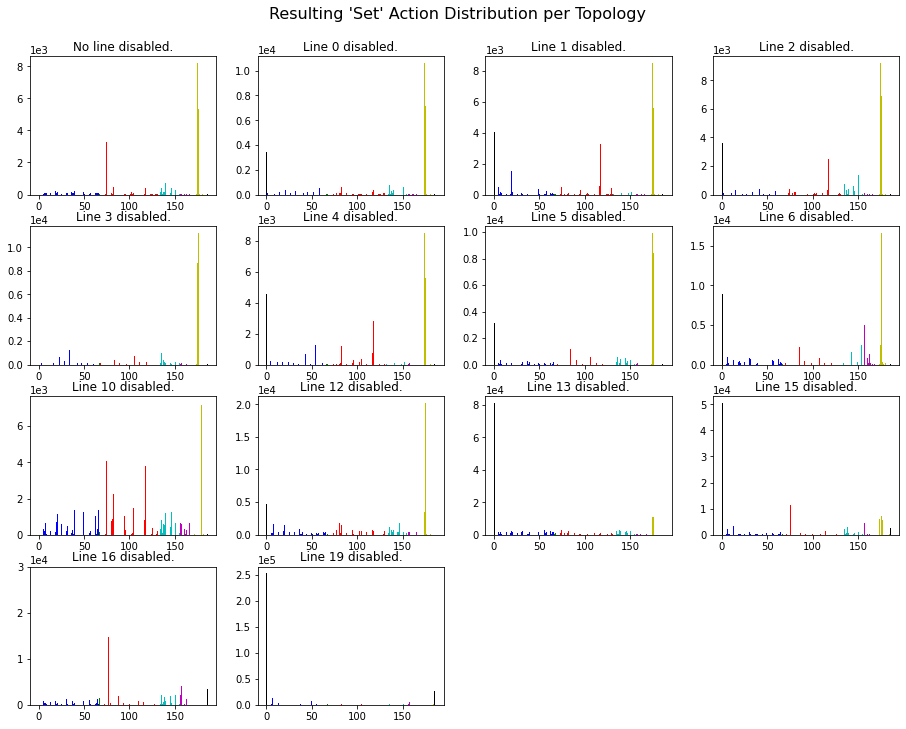

In [21]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
axs = axs.reshape(-1)
fig.tight_layout()

for plt_i, c_i in enumerate(line_disabled_to_consider):
    act_counter = counters[c_i]['unique_set_act']
    weight = [act_counter[i] for i in tups]

    _, _, patches = axs[plt_i].hist(range(len(weight)), weights=weight,bins=range(len(weight)))
    axs[plt_i].title.set_text(f'Line {c_i} disabled.' if c_i>-1 else 'No line disabled.')
    
    #Applying colors
    for j,t in enumerate(tups[:-1]):
        if type(t) == int:
            continue
        patches[j].set_facecolor(colormap[t[0]])
    patches[0].set_facecolor(colormap[-1])
    
    axs[plt_i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting \'Set\' Action Distribution per Topology', fontsize=16, y=1.05)
fig.savefig('action_distribution_per_topology.png', dpi=300)

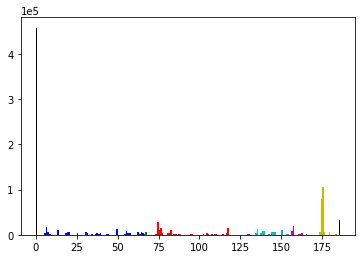

In [22]:
#sorted_tuples = [t[1] for t in sorted([(str(t),t) for t in list(combined_act_counter.keys())])]
weight = [combined_act_counter[i] for i in tups]
#print([x for x in enumerate(act_counter)])
#val, weight = zip(*[(i, v) for i,(k,v) in enumerate(act_counter)])#enumerate(act_counter.most_common())])

#axs[plt_i].hist(, weights=weight,bins=range(len(weight)))
#_ = plt
_, _, patches = plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))

#Applying colors
for j,t in enumerate(tups[:-1]):
    if type(t) == int:
        continue
    patches[j].set_facecolor(colormap[t[0]])
patches[0].set_facecolor(colormap[-1])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [23]:
print(len(combined_act_counter.most_common()),entropy(list(combined_act_counter.values())))
print(len(act_counter_group1.most_common()),entropy(list(act_counter_group1.values())))
print(len(act_counter_group2.most_common()),entropy(list(act_counter_group2.values())))

187 2.8497418815474296
155 2.6021732045977473
106 2.6887887960494217


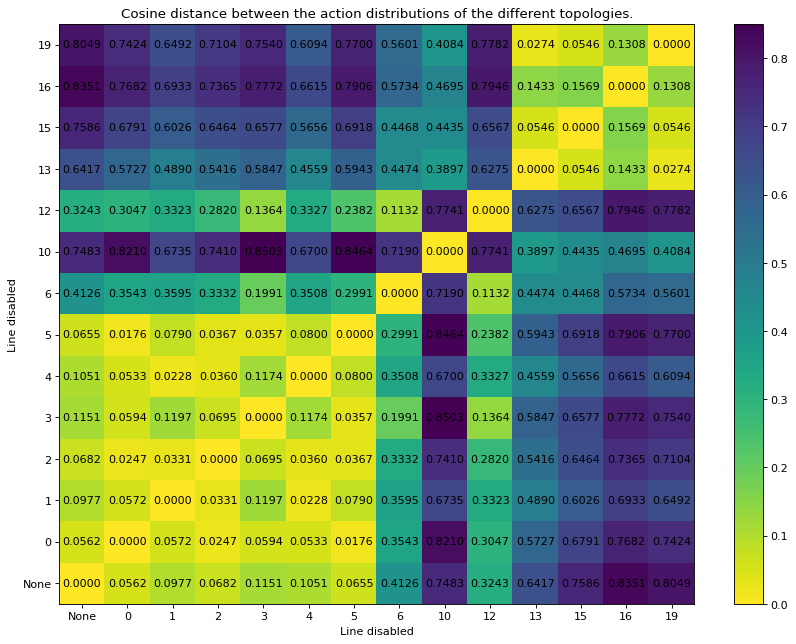

In [24]:
plt.figure(figsize=[2*6.4, 2*4.8], dpi=80)

data = np.random.rand(len(line_disabled_to_consider), len(line_disabled_to_consider))
for iy,y in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
    for ix,x in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
        cosine = distance.cosine([y[a] for a in combined_act_counter.keys()],
                                     [x[a] for a in combined_act_counter.keys()])
        data[iy,ix] = cosine
heatmap = plt.pcolor(data,cmap='viridis_r')

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % data[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap)
plt.xticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.yticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.ylabel('Line disabled')
plt.xlabel('Line disabled')
plt.title('Cosine distance between the action distributions of the different topologies.')
plt.savefig('cosine_distance_actions.png', dpi=300)
plt.show()

In [25]:
(len(combined_act_counter.most_common()),entropy(list(combined_act_counter.values())))

(187, 2.8497418815474296)

### Topology Distribution

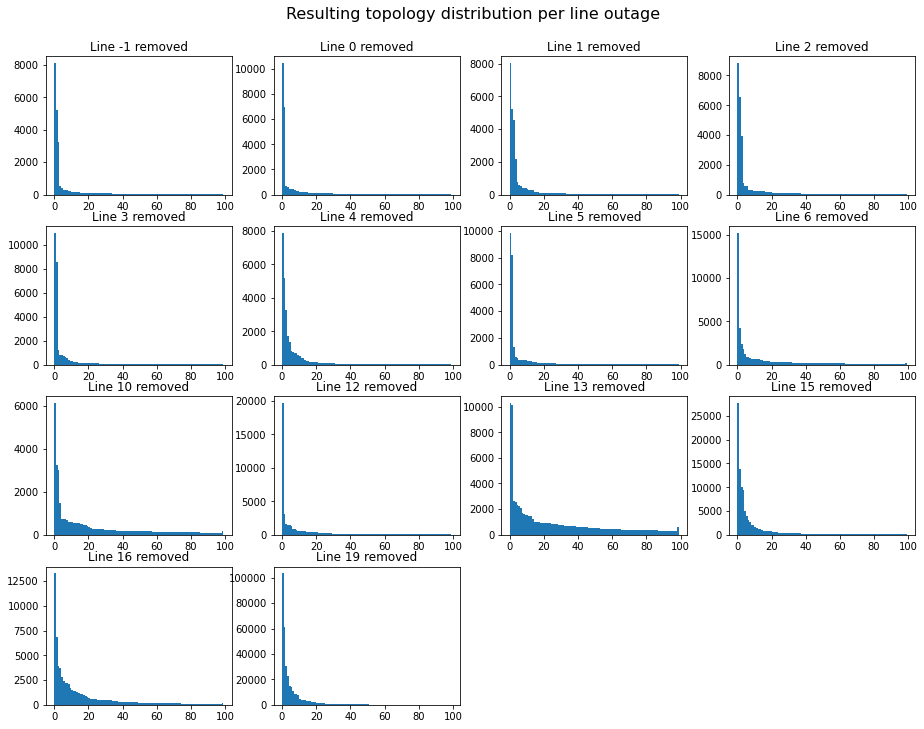

In [26]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
line_disabled_to_show = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_show):
    res_counter = counters[c_i]['res_hash']
    val, weight = zip(*[(i, v) for i,(k,v) in enumerate(res_counter.most_common())])
    axs[plt_i].hist(val[0:100], weights=weight[0:100],bins=val[0:100])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_show)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting topology distribution per line outage', fontsize=16, y=1.05)

### Substations acted on

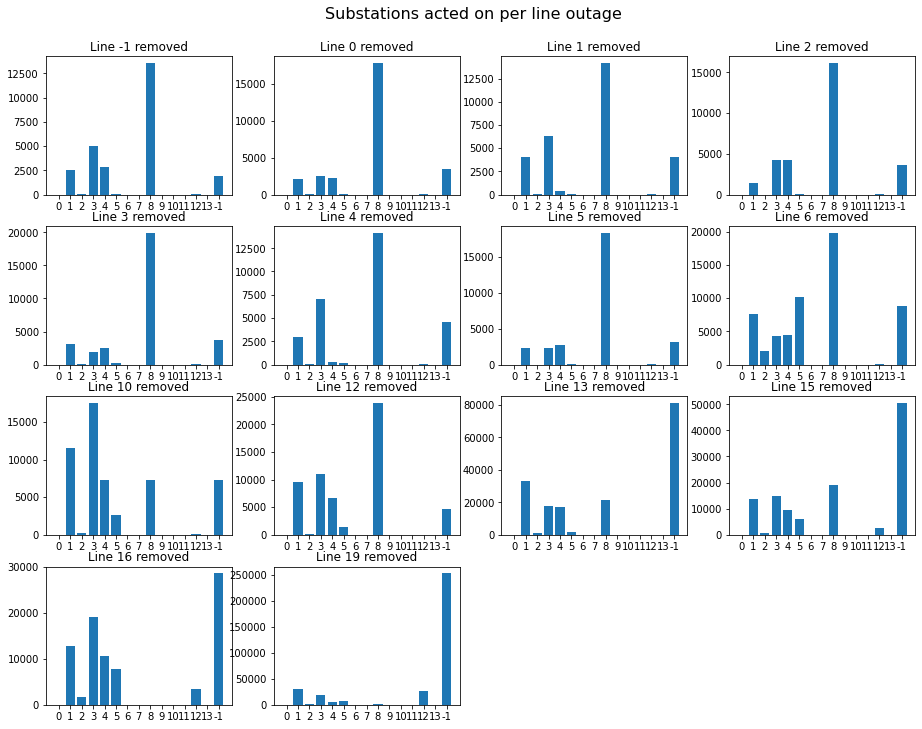

In [27]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
line_disabled_to_show = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_show):
    axs[plt_i].bar([str(n) for n in range(n_sub)]+['-1'],counters[c_i]['sub_changed'])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_show)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Substations acted on per line outage', fontsize=16, y=1.05)

Text(0.5, 1, 'Distribution of Substations Acted On')

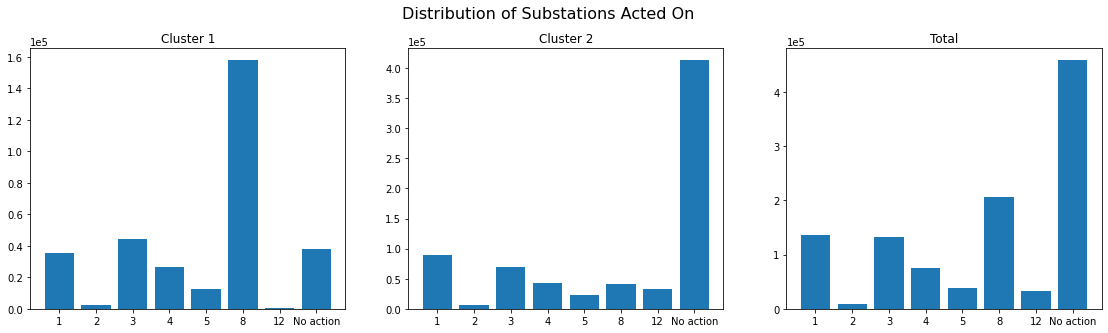

In [28]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])
substations_with_actions = [1,2,3,4,5,8,12,-1]

axs[0].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group1]),axis=0)[substations_with_actions])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group2]),axis=0)[substations_with_actions])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[substations_with_actions])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')

fig.suptitle('Distribution of Substations Acted On', fontsize=16, y=1)
#TODO: remove susbtations that never have any actions

### Topological Depth

In [29]:
do_nothing_action_hashes = [h for h,t in hash_to_act.items() if sum(t)==0]
def mean_index(lst):
    return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)
[(k,mean_index(v['changed_subs_n']))
 for k,v in counters.items() if k in line_disabled_to_consider]

[(-1, 1.4628938560381641),
 (0, 1.438213731848301),
 (1, 1.4000068771061138),
 (2, 1.4232224789845607),
 (3, 1.4536194053606672),
 (4, 1.4313987330936484),
 (5, 1.452562553925798),
 (6, 1.8621290839987448),
 (10, 2.045537680564369),
 (12, 1.9667225657687872),
 (13, 2.699389091497564),
 (15, 1.6278932713824499),
 (16, 2.313645669666238),
 (19, 2.259339811274424)]

In [30]:
counters.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [31]:
print(mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_disabled_to_consider ]),axis=0)))
print(mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group1 ]),axis=0)))
print(mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group2 ]),axis=0)))

2.0652377251594567
1.6094033460995767
2.2687912158492263


In [32]:
print(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in act_counter_group1 ]),axis=0))

[    0 17552  5319  2686   405    29     2     0     0     0     0     0
     0     0]


In [33]:
print(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in act_counter_group2 ]),axis=0))

[    0 17552  5319  2686   405    29     2     0     0     0     0     0
     0     0]


In [34]:
counters.items()

dict_items([(-1, {'n_datapoints': 25993, 'n_days_completed': 27925, 'n_chronics': 1000, 'set_hash': Counter({6276045964240377458: 8226, 7139322632732056517: 5343, -5721075126143512921: 3258, 6863395703212823109: 1859, -2282296054364421215: 747, -8282815993659615711: 480, -8137277979530670165: 435, 8948343713196202813: 400, 8217937256698657323: 399, -8273930761655744384: 395, -5504367326721315962: 293, -4005723459725204751: 254, -1761052162333606757: 246, -2900462415032854431: 241, -6050305657505428504: 163, 8390672397841841386: 158, 5437450700343076312: 153, -5821013951557735324: 141, -4293596048044040975: 136, -1068020512291692217: 135, -280474190058514481: 130, -8396069417900204724: 128, -7115230734079029776: 123, -915411645925564638: 119, 3170674924502356573: 117, 4503695974619440395: 108, 8848382834120629923: 105, -8655490380119618861: 104, -7119528205998241333: 93, -7214018555467379115: 92, 1662776474703228930: 89, 4022157190437222894: 79, 2241549484308876405: 76, -252996273824182

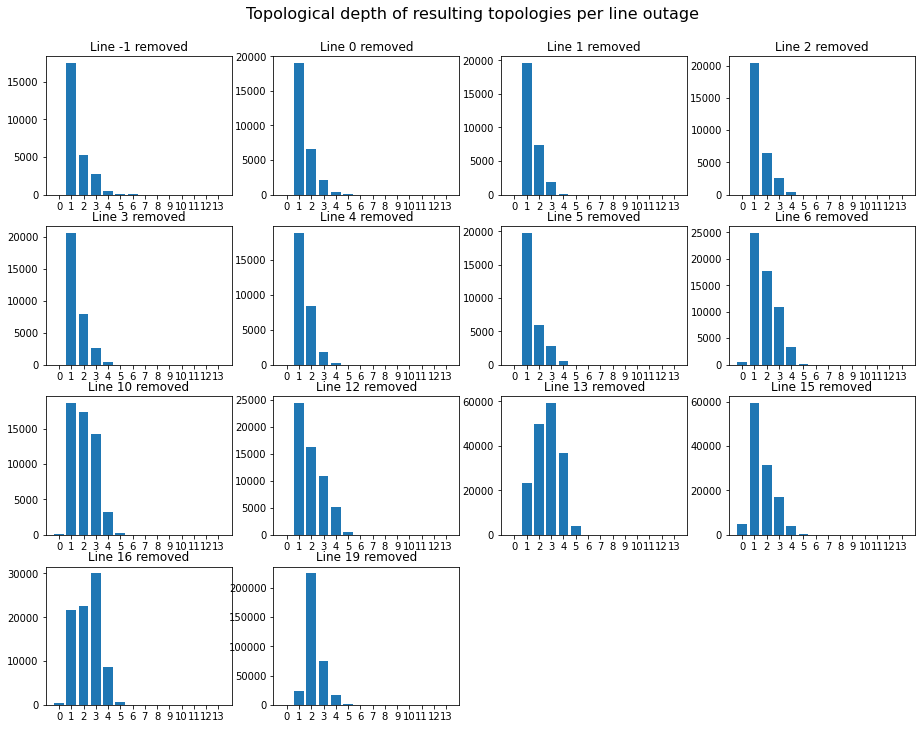

In [35]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
line_disabled_to_show = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_show):
    axs[plt_i].bar([str(n) for n in range(n_sub)],counters[c_i]['changed_subs_n'])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_show)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Topological depth of resulting topologies per line outage', fontsize=16, y=1.05)

#TODO: consider only substation that can be changed

Text(0.5, 1.0, '')

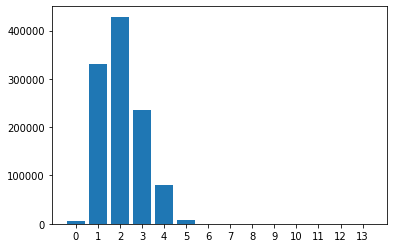

In [36]:
plt.bar([str(n) for n in range(n_sub)],np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                        for c_i in np.arange(-1,20)]),axis=0))
plt.title('')

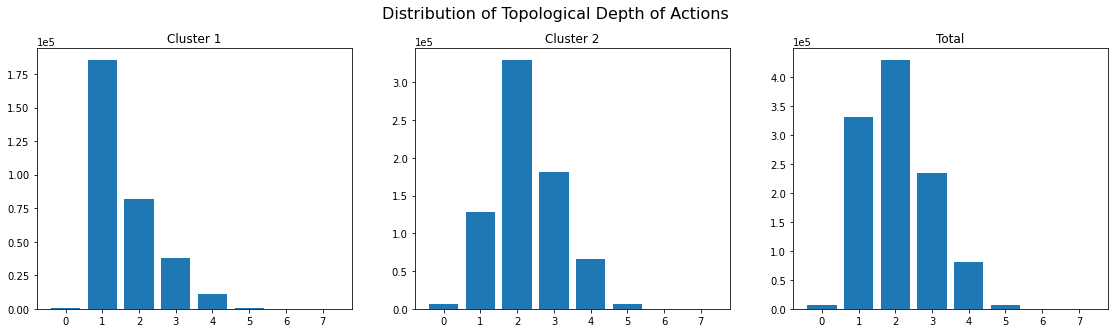

In [37]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])
substations_with_actions = [1,2,3,4,5,8,12,-1]

axs[0].bar(range(len([1,2,3,4,5,8,12,-1])),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group1]),axis=0)[0:8])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar(range(len([1,2,3,4,5,8,12,-1])),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group2]),axis=0)[0:8])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar(range(len([1,2,3,4,5,8,12,-1])),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[0:8])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')


fig.suptitle('Distribution of Topological Depth of Actions', fontsize=16, y=1)
fig.savefig('distribution_topological_depth.png', dpi=300)
#TODO: remove susbtations that never have any actions